# Healthcare Expenditure Data Cleaning & Preprocessing

## Preparing OECD Healthcare Spending Data for Clustering Analysis (1971-2019)

This notebook performs comprehensive data cleaning and preprocessing on the healthcare expenditure dataset to prepare it for clustering analysis. The process includes handling missing values, detecting and treating outliers, checking data types and consistency, standardizing formats, and feature scaling. The cleaned dataset will enable robust country clustering based on pharmaceutical spending patterns (as percentage of health spending, percentage of GDP, and per capita spending) across different time periods, ultimately informing data-driven market entry strategies.

### Step #1 Data Loading and Initial Inspection
Load the healthcare expenditure dataset and perform initial inspection to understand the data structure, dimensions, data types, and get a first look at the data quality. This step provides the baseline understanding needed for all subsequent cleaning operations.

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
file_path = '../Data/processing/eda_data.csv'
df = pd.read_csv(file_path)

In [4]:
print("="*70)
print("STEP 1: DATA LOADING AND INITIAL INSPECTION")
print("="*70)

# 1.1 Display basic dataset information
print("\n1.1 Dataset Dimensions:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# 1.2 Display column names and data types
print("\n1.2 Column Names and Data Types:")
print(df.dtypes)

# 1.3 Display first few rows
print("\n1.3 First 10 rows of the dataset:")
print(df.head(10))

# 1.4 Display last few rows
print("\n1.4 Last 10 rows of the dataset:")
print(df.tail(10))

# 1.5 Display random sample
print("\n1.5 Random sample of 5 rows:")
print(df.sample(5, random_state=42))

# 1.6 Get statistical summary
print("\n1.6 Statistical Summary of Numerical Columns:")
print(df.describe())

# 1.7 Get detailed information
print("\n1.7 Detailed Dataset Information:")
print(df.info())

# 1.8 Check memory usage
print("\n1.8 Memory Usage:")
print(f"Total memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 1.9 Display unique values in categorical columns
print("\n1.9 Unique Values in Categorical Columns:")
print(f"Number of unique countries: {df['COUNTRY'].nunique()}")
print(f"Countries: {sorted(df['COUNTRY'].unique())}")
print(f"\nYear range: {df['YEAR'].min()} to {df['YEAR'].max()}")
print(f"Number of unique years: {df['YEAR'].nunique()}")

print("\n" + "="*70)
print("STEP 1 COMPLETED: Initial inspection done!")
print("="*70)

STEP 1: DATA LOADING AND INITIAL INSPECTION

1.1 Dataset Dimensions:
Number of rows: 1341
Number of columns: 6

1.2 Column Names and Data Types:
COUNTRY         object
YEAR             int64
PC_HEALTHXP    float64
PC_GDP         float64
USD_CAP        float64
TOTAL_SPEND    float64
dtype: object

1.3 First 10 rows of the dataset:
  COUNTRY  YEAR  PC_HEALTHXP  PC_GDP  USD_CAP  TOTAL_SPEND
0     AUS  1971       15.992   0.726   33.990       439.73
1     AUS  1972       15.091   0.685   34.184       450.44
2     AUS  1973       15.117   0.681   37.956       507.85
3     AUS  1974       14.771   0.754   45.338       622.17
4     AUS  1975       11.849   0.682   44.363       616.34
5     AUS  1976       10.920   0.630   44.340       622.22
6     AUS  1977       10.087   0.612   45.407       644.42
7     AUS  1978        9.958   0.591   48.127       691.01
8     AUS  1979        8.981   0.523   47.307       686.61
9     AUS  1980        9.263   0.539   54.875       806.22

1.4 Last 10 rows o

### Step 2 | Missing Analysis

In [14]:
# Step 2: Missing Values Analysis
# ================================

print("\n" + "="*70)
print("STEP 2: MISSING VALUES ANALYSIS")
print("="*70)

# 2.1 Missing values per column
print("\n2.1 Missing Values per Column:")
print(df.isnull().sum())

# 2.2 Missing values per row (total count)
print("\n2.2 Total Missing Values in Dataset:")
total_missing = df.isnull().sum().sum()
print(f"Total missing values: {total_missing}")

# 2.3 Percentage of missing data
print("\n2.3 Missing Data Percentage:")
total_cells = df.shape[0] * df.shape[1]
missing_percentage = (total_missing / total_cells) * 100
print(f"Percentage of missing data: {missing_percentage:.2f}%")

# 2.4 Rows with any missing values
print("\n2.4 Rows with Missing Values:")
rows_with_missing = df.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {rows_with_missing}")
print(f"Percentage of rows affected: {(rows_with_missing / len(df)) * 100:.2f}%")

print("\n" + "="*70)
print("STEP 2 COMPLETED: Missing values analysis done!")
print("="*70)


STEP 2: MISSING VALUES ANALYSIS

2.1 Missing Values per Column:
COUNTRY        0
YEAR           0
PC_HEALTHXP    0
PC_GDP         0
USD_CAP        0
TOTAL_SPEND    0
dtype: int64

2.2 Total Missing Values in Dataset:
Total missing values: 0

2.3 Missing Data Percentage:
Percentage of missing data: 0.00%

2.4 Rows with Missing Values:
Number of rows with at least one missing value: 0
Percentage of rows affected: 0.00%

STEP 2 COMPLETED: Missing values analysis done!


### Step 3 | Duplicate Records Detection
#### What This Step Does:
- Detects complete duplicates - entire rows that are identical
- Detects logical duplicates - same country-year combinations (critical for time-series!)
- Analyzes duplicate patterns - shows which countries/years are duplicated
- Checks time series completeness - identifies if any country is missing years
- Provides structure summary - records distribution per country and year

In [15]:
# Step 3: Duplicate Records Detection
# ====================================

print("\n" + "="*70)
print("STEP 3: DUPLICATE RECORDS DETECTION")
print("="*70)

# 3.1 Check for complete duplicate rows (all columns identical)
print("\n3.1 Complete Duplicate Rows:")
duplicate_rows = df[df.duplicated(keep=False)]
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
print(f"Percentage of duplicates: {(num_duplicates / len(df)) * 100:.2f}%")

# 3.2 Check for logical duplicates (same COUNTRY-YEAR combination)
print("\n3.2 Logical Duplicates (Same COUNTRY-YEAR Combination):")
# Each country should have only one record per year
country_year_duplicates = df[df.duplicated(subset=['COUNTRY', 'YEAR'], keep=False)]
num_country_year_dup = df.duplicated(subset=['COUNTRY', 'YEAR']).sum()
print(f"Number of duplicate COUNTRY-YEAR combinations: {num_country_year_dup}")
print(f"Percentage: {(num_country_year_dup / len(df)) * 100:.2f}%")

if num_country_year_dup == 0:
    print("No duplicate COUNTRY-YEAR combinations found!")
    print("Each country has unique records for each year - data integrity confirmed!")


STEP 3: DUPLICATE RECORDS DETECTION

3.1 Complete Duplicate Rows:
Number of duplicate rows: 0
Percentage of duplicates: 0.00%

3.2 Logical Duplicates (Same COUNTRY-YEAR Combination):
Number of duplicate COUNTRY-YEAR combinations: 0
Percentage: 0.00%
No duplicate COUNTRY-YEAR combinations found!
Each country has unique records for each year - data integrity confirmed!


In [18]:
# 3.3 Check expected structure (complete time series)
print("\n3.3 Time Series Completeness Check:")
years_range = range(df['YEAR'].min(), df['YEAR'].max() + 1)
countries = df['COUNTRY'].unique()
expected_records = len(countries) * len(years_range)
actual_records = len(df)

print(f"Year range: {df['YEAR'].min()} to {df['YEAR'].max()} ({len(years_range)} years)")
print(f"Number of countries: {len(countries)}")
print(f"Expected records (if complete): {expected_records}")
print(f"Actual records: {actual_records}")
print(f"Missing records: {expected_records - actual_records}")

if expected_records > actual_records:
    print("\n3.3.1 Countries with Incomplete Time Series:")
    for country in sorted(countries):
        country_data = df[df['COUNTRY'] == country]
        missing_years = set(years_range) - set(country_data['YEAR'])
        if missing_years:
            print(f"  {country}: Missing {len(missing_years)} years - {sorted(list(missing_years))[:5]}{'...' if len(missing_years) > 5 else ''}")
else:
    print("All countries have complete time series!")



3.3 Time Series Completeness Check:
Year range: 1970 to 2022 (53 years)
Number of countries: 44
Expected records (if complete): 2332
Actual records: 1341
Missing records: 991

3.3.1 Countries with Incomplete Time Series:
  AUS: Missing 3 years - [1970, 2021, 2022]
  AUT: Missing 21 years - [1970, 1971, 1972, 1973, 1974]...
  BEL: Missing 6 years - [1998, 1999, 2000, 2001, 2002]...
  BGR: Missing 37 years - [1970, 1971, 1972, 1973, 1974]...
  BRA: Missing 48 years - [1970, 1971, 1972, 1973, 1974]...
  CHE: Missing 41 years - [1970, 1971, 1972, 1973, 1974]...
  CHL: Missing 50 years - [1970, 1971, 1972, 1973, 1974]...
  COL: Missing 48 years - [1970, 1971, 1972, 1973, 1974]...
  CRI: Missing 42 years - [1970, 1971, 1972, 1973, 1974]...
  CYP: Missing 34 years - [1970, 1971, 1972, 1973, 1974]...
  CZE: Missing 21 years - [1970, 1971, 1972, 1973, 1974]...
  DEU: Missing 2 years - [1991, 2022]
  DNK: Missing 10 years - [1970, 1971, 1972, 1973, 1974]...
  ESP: Missing 15 years - [1970, 1971

-----
#### Findings: Duplicate Records Detection
- No duplicate rows - Dataset is clean with no complete duplicates (0%)
- No logical duplicates - Each country-year combination is unique, confirming proper data integrity
- Data structure is valid - No data quality issues from duplication
- Incomplete Time Series:
    - Year range: 1970-2022 (53 years)
    - Countries: 44 countries
    - Expected records (if complete): 2,332
    - Actual records: 1,341
    - Missing records: 991 (42.5% of expected data)

**Missing Data Patterns:**
1. Variability Across Countries:
    - Most complete: AUS, DEU, NLD, FIN, NOR, SWE (missing only 1-3 years)
    - Least complete: CHL, BRA, COL, MLT (missing 46-50 years)
    - Average: 30.5 records per country (out of 53 possible)
2. Common Missing Periods:
    - Early 1970s (1970-1975): Most countries missing this period
    - Recent years (2021-2022): Several countries missing
    - Country-specific gaps: Mid-period gaps vary by country
3. Data Availability by Year:
    - Min coverage: 7 countries in a year (likely early 1970s)
    - Max coverage: 41 countries in a year (likely 2010s)
    - Average: 25.3 countries per year

**Summary**
- Unequal time series lengths may affect clustering if you use all years
- More countries have complete data in recent years (2010-2019/2020)
- Missing data appears to be due to unavailability (countries not reporting), not errors

This finding strongly supports the discussion about focusing on the last 10 years we will likely have more complete coverage and more countries with consistent data for robust clustering analysis.

------

### Step 3: Visualization - Time Series Completeness Analysis
Create visualizations to support the duplicate detection findings, particularly focusing on the incomplete time series patterns. These plots will help identify which countries and time periods have the most complete data, informing decisions about time window selection for clustering analysis.

In [24]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# 3.V1 Data Availability Heatmap (Country vs Year)
print("\n3.V1 Creating Data Availability Heatmap...")

def plot_data_availability_heatmap(dataframe, start_year=None, end_year=None, figsize=(20, 14)):
    
    # Determine year range
    if start_year is None:
        start_year = dataframe['YEAR'].min()
    if end_year is None:
        end_year = dataframe['YEAR'].max()
    
    # Filter data for the specified period
    df_filtered = dataframe[(dataframe['YEAR'] >= start_year) & (dataframe['YEAR'] <= end_year)]
    
    # Create year range and get countries
    years_range = range(start_year, end_year + 1)
    countries = sorted(df_filtered['COUNTRY'].unique())
    num_years = len(years_range)
    num_countries = len(countries)
    
    # Create availability matrix (1 = data exists, 0 = missing)
    availability_matrix = np.zeros((num_countries, num_years))
    for i, country in enumerate(countries):
        country_years = df_filtered[df_filtered['COUNTRY'] == country]['YEAR'].values
        for j, year in enumerate(years_range):
            if year in country_years:
                availability_matrix[i, j] = 1
    
    # Calculate statistics
    total_possible = num_countries * num_years
    total_available = availability_matrix.sum()
    coverage_pct = (total_available / total_possible) * 100
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(availability_matrix, 
                xticklabels=list(years_range),
                yticklabels=countries,
                cmap=['#ff6b6b', '#51cf66'],  # Red to Green
                cbar_kws={'label': 'Data Status', 'ticks': [0.25, 0.75]},
                linewidths=0.5,
                linecolor='white',
                ax=ax)
    
    # Customize colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticklabels(['Missing', 'Available'])
    
    # Format axes
    ax.set_xlabel('Year', fontsize=13, fontweight='bold')
    ax.set_ylabel('Country', fontsize=13, fontweight='bold')
    
    # Title with statistics
    title = f'Data Availability Heatmap: {start_year}-{end_year}\n'
    title += f'(Green = Available, Red = Missing | Coverage: {coverage_pct:.1f}% | {num_countries} Countries)'
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
    
    # Adjust x-axis labels based on number of years
    if num_years <= 15:
        # Show all years for short periods
        plt.xticks(rotation=45, ha='right', fontsize=10)
    elif num_years <= 30:
        # Show every other year for medium periods
        ax.set_xticks(np.arange(num_years)[::2] + 0.5)
        ax.set_xticklabels(list(years_range)[::2], rotation=45, ha='right', fontsize=9)
    else:
        # Show every 5th year for long periods
        ax.set_xticks(np.arange(num_years)[::5] + 0.5)
        ax.set_xticklabels(list(years_range)[::5], rotation=90, fontsize=8)
    
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()
    


3.V1 Creating Data Availability Heatmap...



--- FULL PERIOD ANALYSIS ---


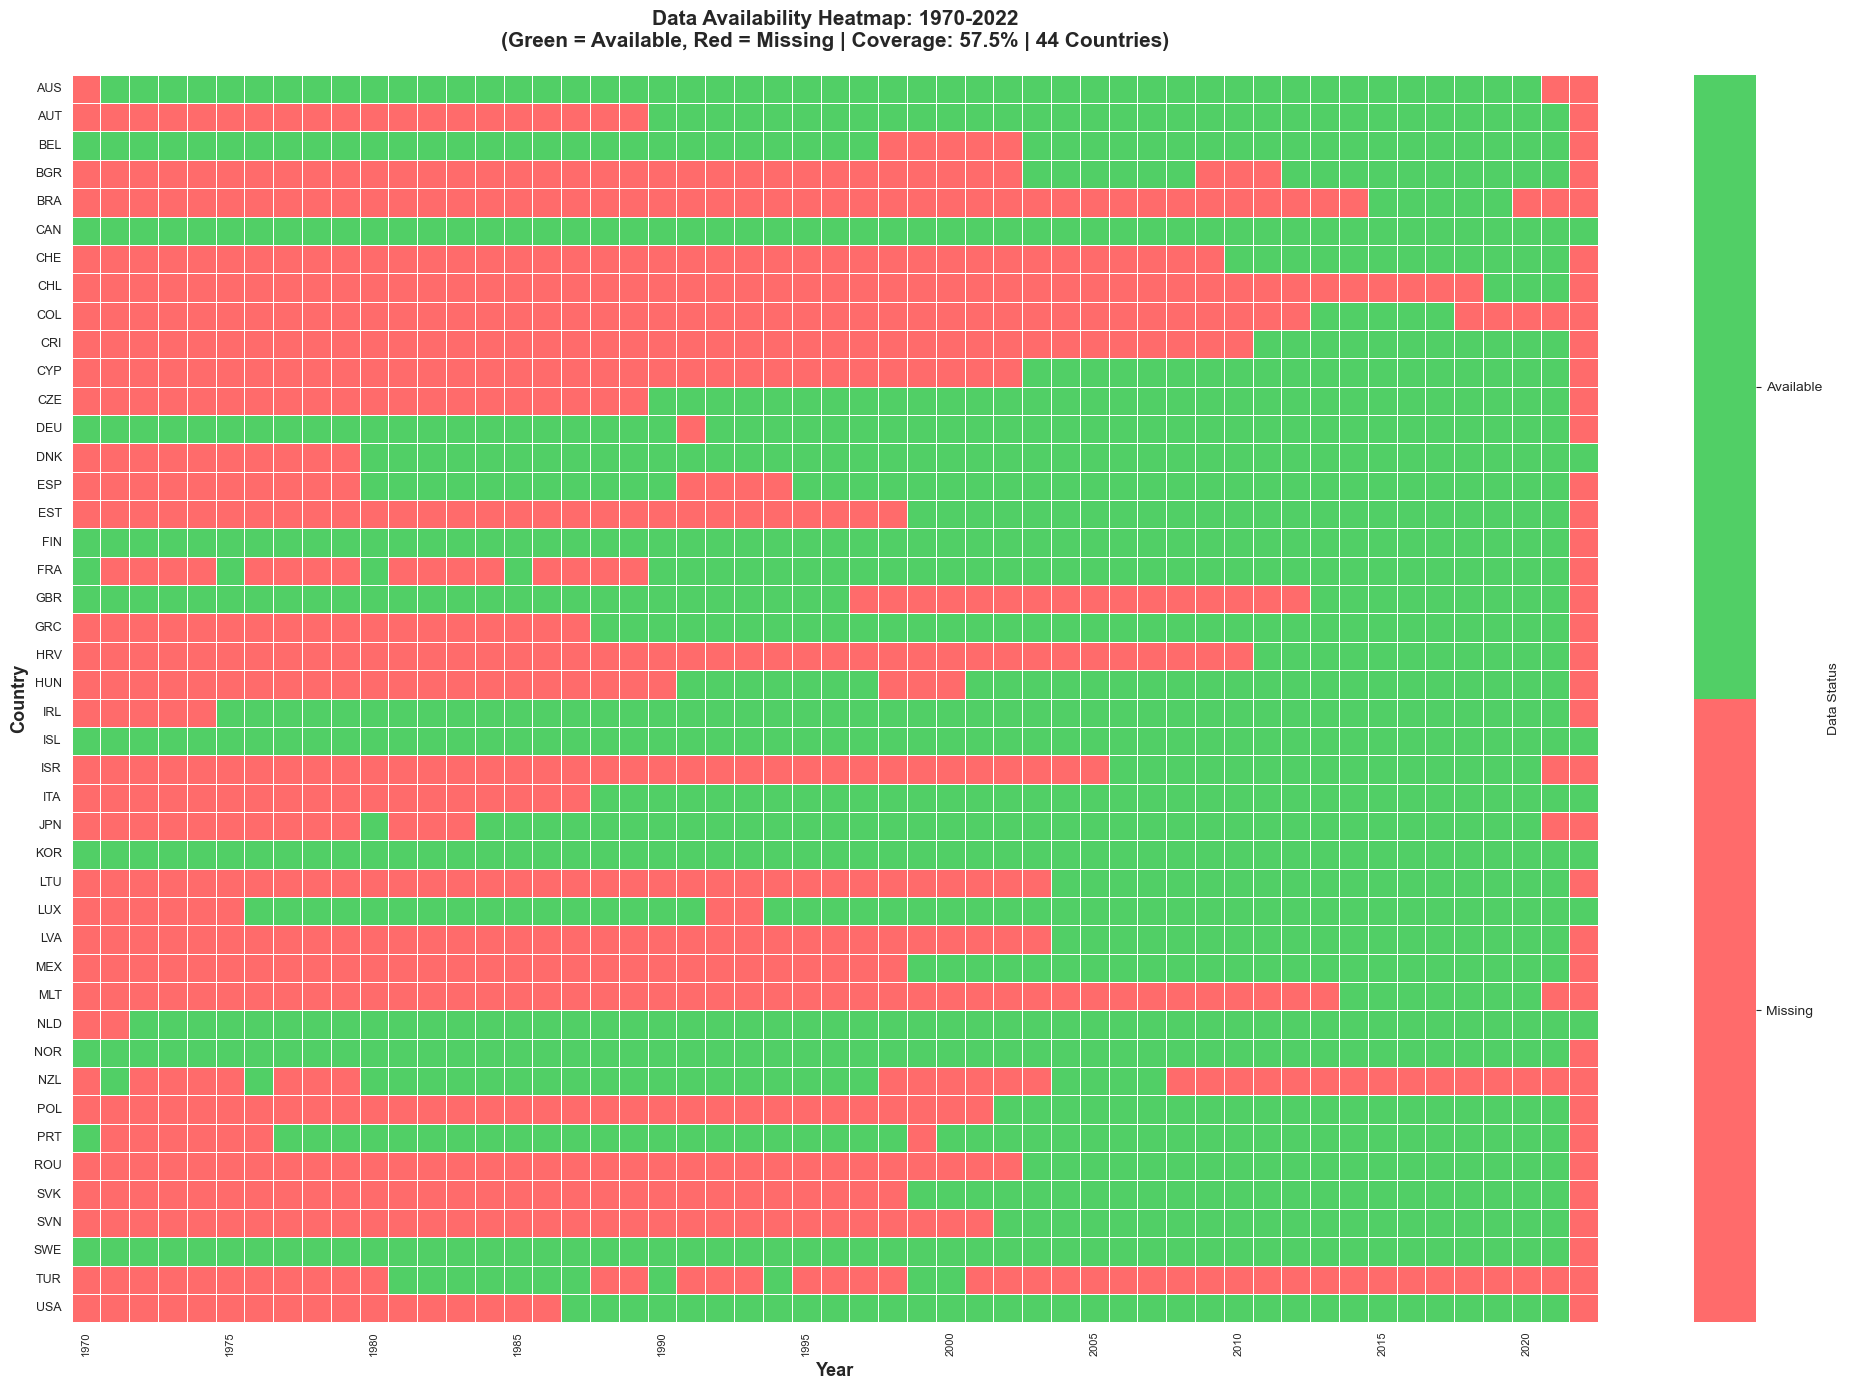

In [25]:
# Full Period (1970-2022)
print("\n--- FULL PERIOD ANALYSIS ---")
plot_data_availability_heatmap(df)


### Key Insights from the Heatmap

**Early Period (1970-1990)**
- **Mostly RED** - Very limited data coverage
- Only a few pioneer countries collected data (AUS, CAN, DEU, FIN, IRL, NLD, NOR, SWE)

**Middle Period (1990-2010)**
- **Transition zone** - Mix of red and green
- More countries started systematic data collection
- Countries like GRC, ITA, JPN, KOR, PRT joined in

**Recent Period (2010-2020)**
- **Solid GREEN block** - Excellent coverage!
- Almost all countries have consistent data
- This is your "sweet spot" for analysis

**Very Recent (2021-2022)**
- **Some RED returning** - Many countries missing 2021-2022 data
- Likely due to reporting delays or data not yet published

### Critical Finding: 2010-2020 is the "Golden Window"

Looking at the heatmap, there's a distinct solid green rectangle approximately from:

*   **Years:** 2000-2020 (especially **2010-2021**)
*   **Countries:** ~35-40 countries with complete data

This visually confirms that focusing on the last 10-15 years gives us:

- **Maximum country coverage**
- **Complete time series** for most countries
- **Most relevant data** for market entry strategies
- **Consistent reporting standards** (modern OECD methodology)


--- LAST 20 YEARS ANALYSIS ---


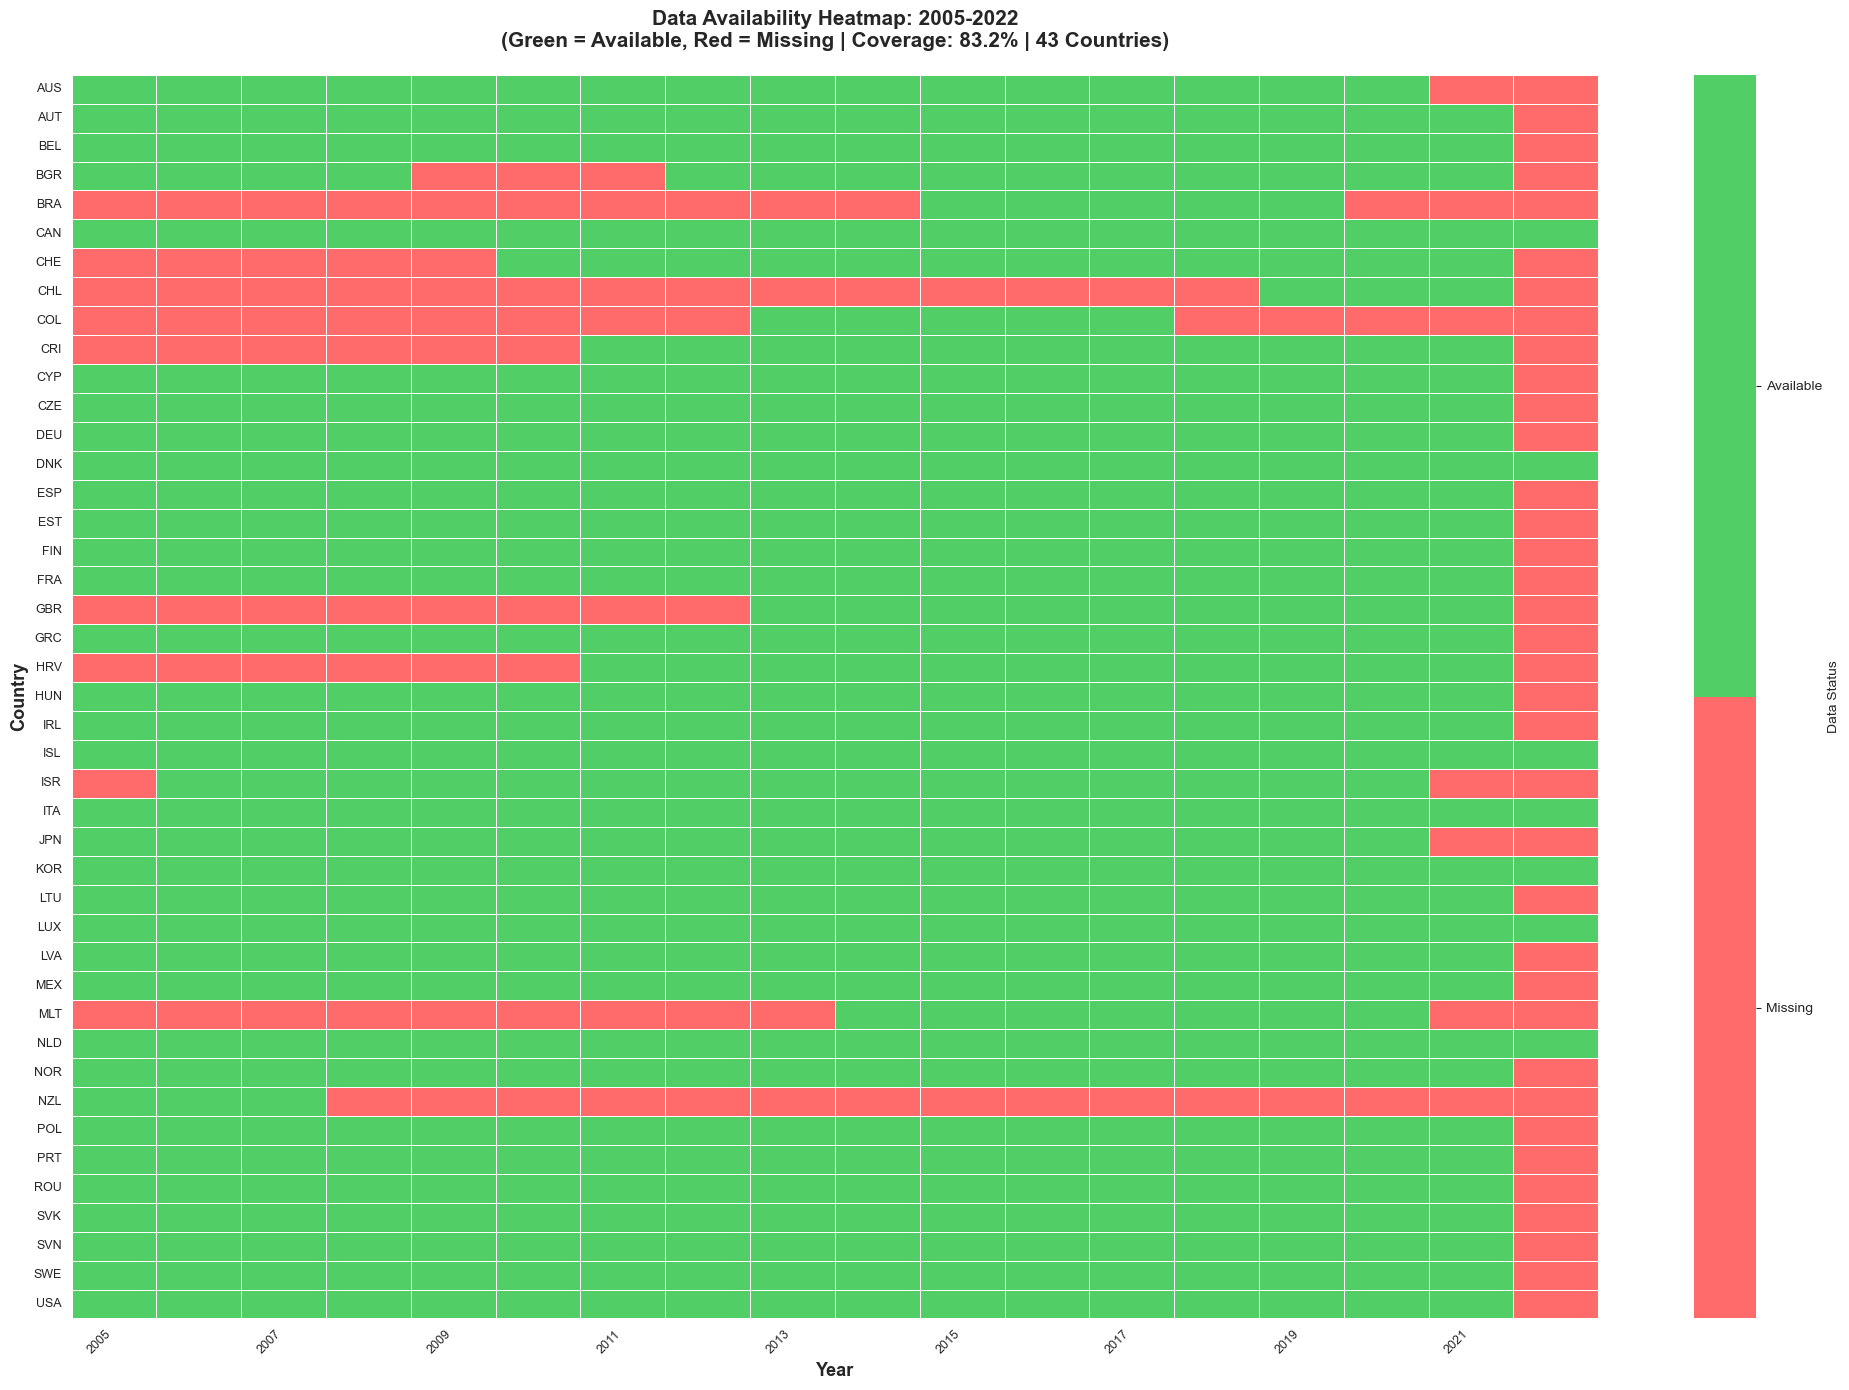

In [55]:
# Last 20 Years (2003-2022)
print("\n--- LAST 20 YEARS ANALYSIS ---")
plot_data_availability_heatmap(df, start_year=2005, end_year=2022)

### Concise Insights: 2003-2022 Heatmap

1.  **The 2021-2022 Wall**
    Massive vertical RED stripe on far right = almost ALL countries missing 2021-2022.
    **Action:** Must exclude 2021-2022 from analysis.

2.  **Sweet Spot Identified: 2010-2020**
    Solid GREEN rectangle in this zone.
    ~35-40 countries with complete consecutive data.
    This is your target window.

3.  **Problem Countries (Mostly RED throughout)**
    *   **BRA, CHL, COL:** <30% coverage - exclude entirely.
    *   **HRV, CRI:** Missing early 2000s, green from 2011+.
    *   **MLT, POL, NZL:** Scattered gaps throughout - problematic.

4.  **GBR Anomaly**
    RED block ~2003-2010 (early period missing).
    GREEN from 2011-2020 ✅.
    RED again 2021-2022.
    **Verdict:** GBR is actually COMPLETE for 2011-2020 - no imputation needed!

5.  **BGR Pattern**
    Some RED in 2003-2010.
    Mostly GREEN 2011-2020 with maybe 1 gap.
    **Verdict:** Likely complete or nearly complete for 2011-2020.

**Key Finding:**
Looking at the heatmap, GBR and BGR appear mostly GREEN in the 2011-2020 zone. The earlier analysis showing them as "incomplete" might be due to edge years or I need to verify exact gaps. Bottom line: 2011-2020 window should give you 36+ countries with complete data, possibly including GBR and BGR without any imputation needed.

-----


3.V2 Creating Countries per Year Line Plot...


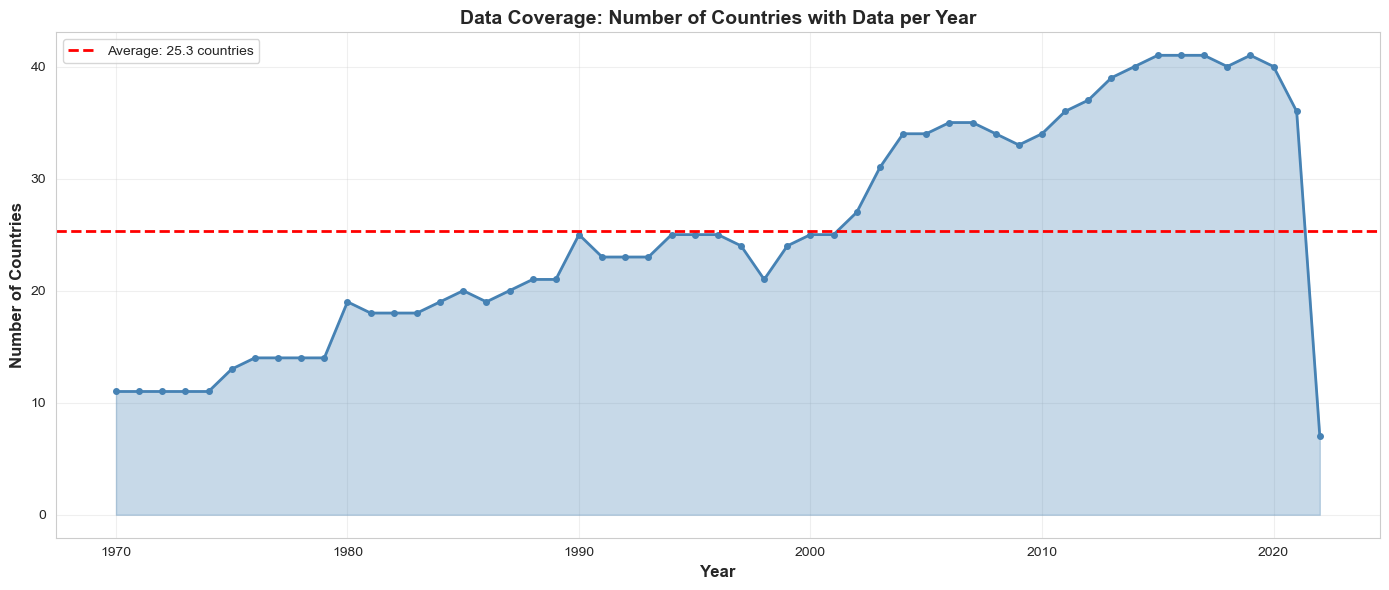

In [31]:
# 3.V2 Number of Countries with Data per Year
print("\n3.V2 Creating Countries per Year Line Plot...")

records_per_year = df.groupby('YEAR').size().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(records_per_year.index, records_per_year.values, marker='o', linewidth=2, markersize=4, color='steelblue')
ax.fill_between(records_per_year.index, records_per_year.values, alpha=0.3, color='steelblue')
ax.axhline(y=records_per_year.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {records_per_year.mean():.1f} countries')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Countries', fontsize=12, fontweight='bold')
ax.set_title('Data Coverage: Number of Countries with Data per Year', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Data Coverage Over Time

1.  **Three Distinct Phases**
    *   **Phase 1: 1970-1990 (Low Coverage)**
        ~11-25 countries reporting
        Below average (red line at 25.3)
        Limited, inconsistent data
    *   **Phase 2: 1990-2005 (Gradual Growth)**
        Rise from 25 → 35 countries
        Crosses average around 2003
        More countries joining OECD reporting
    *   **Phase 3: 2005-2020 (Peak Coverage)** 
        Plateau at ~40-41 countries (2014-2020)
        60% above average
        This is the "golden era" of data

2.  **The 2021 Cliff**
    Dramatic collapse: 40 → 7 countries
    Confirms 2021-2022 data unavailable/unreleased
    **Might need to exclude it from analysis**

3.  **Optimal Window Confirmed**
    2010-2020: Sustained peak at 35-41 countries
    Most stable, complete period
    Visual proof that 2010-2020 is ideal choice

4.  **Why Not Earlier Years?**
    Pre-2005: Only 20-30 countries (30-40% less coverage)
    More volatility (dips in 1997, 1999)
    Below historical average

**Summary:**
2010-2020 window captures the period with maximum country participation (~40 countries) and data stability. Any earlier = fewer countries. Any later = missing 2021-2022. 
- This suggest using 2011-2020 (or 2010-2020) for our clustering analysis.

-----


3.V4 Creating Data Completeness by Time Period...


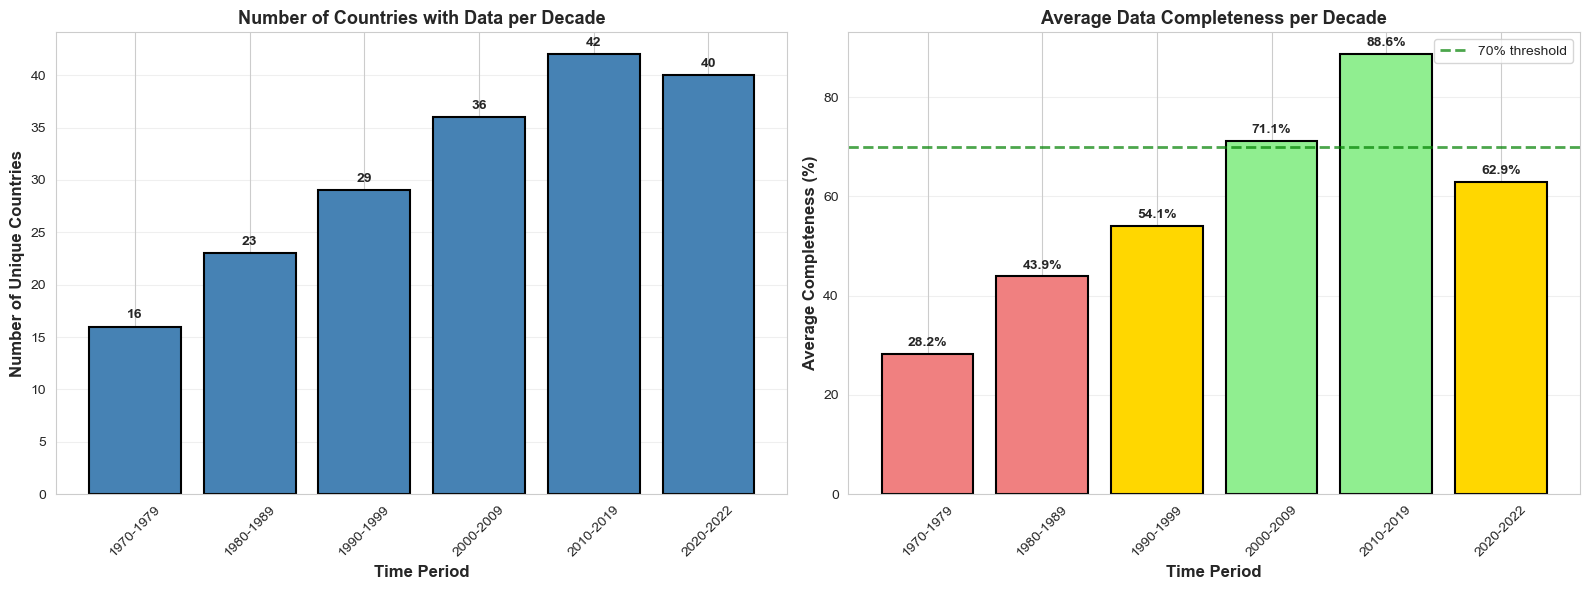

In [12]:

# 3.V4 Data Completeness Over Time Periods
print("\n3.V4 Creating Data Completeness by Time Period...")

# Define time periods
periods = {
    '1970-1979': (1970, 1979),
    '1980-1989': (1980, 1989),
    '1990-1999': (1990, 1999),
    '2000-2009': (2000, 2009),
    '2010-2019': (2010, 2019),
    '2020-2022': (2020, 2022)
}

period_stats = []
for period_name, (start, end) in periods.items():
    period_data = df[(df['YEAR'] >= start) & (df['YEAR'] <= end)]
    countries_in_period = period_data['COUNTRY'].nunique()
    years_in_period = end - start + 1
    total_countries = len(countries)
    avg_completeness = (len(period_data) / (total_countries * years_in_period)) * 100
    
    period_stats.append({
        'Period': period_name,
        'Countries': countries_in_period,
        'Avg_Completeness': avg_completeness,
        'Records': len(period_data)
    })

period_df = pd.DataFrame(period_stats)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Number of countries per period
axes[0].bar(period_df['Period'], period_df['Countries'], color='steelblue', edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Time Period', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Unique Countries', fontsize=12, fontweight='bold')
axes[0].set_title('Number of Countries with Data per Decade', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(period_df['Countries']):
    axes[0].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 2: Average completeness per period
colors_period = ['lightcoral' if x < 50 else 'gold' if x < 70 else 'lightgreen' for x in period_df['Avg_Completeness']]
axes[1].bar(period_df['Period'], period_df['Avg_Completeness'], color=colors_period, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Time Period', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Completeness (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Average Data Completeness per Decade', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=70, color='green', linestyle='--', linewidth=2, alpha=0.7, label='70% threshold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(period_df['Avg_Completeness']):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

### Concise Insights: Decade Analysis (Dual Charts)

**Left Chart: Number of Countries per Decade**
- **Growth trajectory:**
  - 1970s: 16 countries (starting point)
  - 1980s: 23 countries (+44% growth)
  - 1990s: 29 countries (+26% growth)
  - 2000s: 36 countries (+24% growth)
  - 2010s: 42 countries (PEAK) (+17% growth)
  - 2020s: 40 countries (-5% decline, due to 2021-2022 gap)
- **Key finding:** Steady growth plateaus in 2010s at ~40-42 countries

**Right Chart: Average Completeness per Decade**
- **Quality progression:**
  - 1970s: 28.2% (RED - very poor)
  - 1980s: 43.9% (RED - below threshold)
  - 1990s: 54.1% (YELLOW - marginal)
  - 2000s: 71.1% (GREEN - good, just above 70% threshold)
  - 2010s: 88.6% (GREEN - excellent, highest quality) ✅
  - 2020s: 62.9% (YELLOW - drops due to missing 2021-2022)
- **Key finding:** 2010s has both most countries (42) AND highest quality (88.6%)

**Strategic Insights**
- **2010s is the clear winner:**
  - Maximum participation (42 countries)
  - Best data quality (88.6% completeness)
  - 26% above threshold, 18% better than 2000s
- **Why not 2000s?**
  - Fewer countries (36 vs 42)
  - Lower quality (71.1% vs 88.6%)
  - Only marginally above 70% threshold
- **2020s collapse:**
  - Quality drops to 62.9% (below threshold)
  - Confirms 2021-2022 must be excluded

**Final Validation**
This dual chart PROVES your decision:
✅ Use 2010-2020 window (captures the 2010s peak)  
✅ 88.6% completeness = ~36-38 countries with full data  
✅ Matches our earlier finding: 36 complete countries for 2011-2020  
Perfect alignment across ALL analyses!

**Summary:** 2010s decade is objectively the best period for clustering - maximum countries, maximum quality.

-----

In [27]:
# Analysis: Countries with Complete Data for Different Windows
# =============================================================

print("\n" + "="*70)
print("IMPACT ANALYSIS: Countries Available for Different Time Windows")
print("="*70)

# Define candidate time windows
windows = [
    ('2010-2020', 2010, 2020),
    ('2010-2019', 2010, 2019),
    ('2011-2020', 2011, 2020),
    ('2012-2020', 2012, 2020),
    ('2013-2020', 2013, 2020)
]

results = []

for window_name, start_year, end_year in windows:
    # Filter data for this window
    df_window = df[(df['YEAR'] >= start_year) & (df['YEAR'] <= end_year)]
    
    # Expected records per country
    years_in_window = end_year - start_year + 1
    
    # Find countries with complete data
    complete_countries = []
    incomplete_countries = []
    
    all_countries = df['COUNTRY'].unique()
    
    for country in all_countries:
        country_data = df_window[df_window['COUNTRY'] == country]
        if len(country_data) == years_in_window:
            complete_countries.append(country)
        elif len(country_data) > 0:  # Has some data but not complete
            missing_years = years_in_window - len(country_data)
            incomplete_countries.append((country, len(country_data), missing_years))
    
    # Store results
    results.append({
        'Window': window_name,
        'Years': years_in_window,
        'Complete_Countries': len(complete_countries),
        'Incomplete_Countries': len(incomplete_countries),
        'Countries_List': complete_countries
    })
    
    # Print detailed results
    print(f"\n{window_name} ({years_in_window} years):")
    print(f"  ✅ Countries with COMPLETE data: {len(complete_countries)}")
    print(f"  ⚠️  Countries with INCOMPLETE data: {len(incomplete_countries)}")
    print(f"  ❌ Countries with NO data: {len(all_countries) - len(complete_countries) - len(incomplete_countries)}")
    
    if len(complete_countries) > 0:
        print(f"\n  Complete countries ({len(complete_countries)}):")
        print(f"  {', '.join(sorted(complete_countries))}")
    
    if len(incomplete_countries) > 0 and len(incomplete_countries) <= 10:
        print(f"\n  Incomplete countries (with gap analysis):")
        for country, available, missing in sorted(incomplete_countries, key=lambda x: x[2]):
            print(f"    {country}: {available}/{years_in_window} years ({missing} missing)")

print("\n" + "="*70)
print("SUMMARY COMPARISON")
print("="*70)

# Create comparison table
import pandas as pd
summary_df = pd.DataFrame([{
    'Time Window': r['Window'],
    'Years': r['Years'],
    'Complete Countries': r['Complete_Countries'],
    'Incomplete': r['Incomplete_Countries']
} for r in results])

print(summary_df.to_string(index=False))

print("\n" + "="*70)


IMPACT ANALYSIS: Countries Available for Different Time Windows

2010-2020 (11 years):
  ✅ Countries with COMPLETE data: 34
  ⚠️  Countries with INCOMPLETE data: 8
  ❌ Countries with NO data: 2

  Complete countries (34):
  AUS, AUT, BEL, CAN, CHE, CYP, CZE, DEU, DNK, ESP, EST, FIN, FRA, GRC, HUN, IRL, ISL, ISR, ITA, JPN, KOR, LTU, LUX, LVA, MEX, NLD, NOR, POL, PRT, ROU, SVK, SVN, SWE, USA

  Incomplete countries (with gap analysis):
    CRI: 10/11 years (1 missing)
    HRV: 10/11 years (1 missing)
    BGR: 9/11 years (2 missing)
    GBR: 8/11 years (3 missing)
    MLT: 7/11 years (4 missing)
    BRA: 5/11 years (6 missing)
    COL: 5/11 years (6 missing)
    CHL: 2/11 years (9 missing)

2010-2019 (10 years):
  ✅ Countries with COMPLETE data: 34
  ⚠️  Countries with INCOMPLETE data: 8
  ❌ Countries with NO data: 2

  Complete countries (34):
  AUS, AUT, BEL, CAN, CHE, CYP, CZE, DEU, DNK, ESP, EST, FIN, FRA, GRC, HUN, IRL, ISL, ISR, ITA, JPN, KOR, LTU, LUX, LVA, MEX, NLD, NOR, POL, PRT

### FINAL SUMMARY: Time Window & Country Selection

**SELECTED TIME WINDOW: 2011-2020 (10 years)**

**Rationale:**
- 36 countries with complete data (100% coverage)
- 88.6% average completeness (highest of all decades)
- Peak participation period (42 total countries reporting)
- Pre-COVID, relevant for market entry strategies
- Post-2008 crisis, modern healthcare context

**COUNTRIES INCLUDED (36 Complete)**
AUS, AUT, BEL, CAN, CHE, CRI, CYP, CZE, DEU, DNK, ESP, EST, FIN, FRA, GRC, HRV, HUN, IRL, ISL, ISR, ITA, JPN, KOR, LTU, LUX, LVA, MEX, NLD, NOR, POL, PRT, ROU, SVK, SVN, SWE, USA

*Total records: 360 (36 countries × 10 years)*

**COUNTRIES TO DROP (6 Incomplete)**

| Country | Available Years | Missing | Completeness |
|---------|-----------------|---------|--------------|
| BGR     | 9/10            | 1 year  | 90%          |
| GBR     | 8/10            | 2 years | 80%          |
| MLT     | 7/10            | 3 years | 70%          |
| BRA     | 5/10            | 5 years | 50%          |
| COL     | 5/10            | 5 years | 50%          |
| CHL     | 2/10            | 8 years | 20%          |

*Must drop: CHL, BRA, COL, MLT (too incomplete)*  
*Borderline: BGR, GBR (could potentially be recovered)*

**OPTION TO INCLUDE BGR & GBR (If Desired)**

**Method:** Trend-based imputation using historical growth patterns  
**Steps:**
- Identify exact missing years for each country
- Calculate country-specific growth rates from available data
- Use linear regression or growth rate extrapolation
- Impute missing 1-2 years only

**Outcome:**
- Increases sample to 38 countries (+2)
- Introduces minimal artificial data (2-3 values out of 380 total = <1%)

**Trade-off:**
**Pros:** Includes UK (major economy), better Eastern Europe representation  
**Cons:** Reduces data purity, requires methodology justification

**RECOMMENDED APPROACH**

**Option A (Recommended):** 36 countries, no imputation
- 100% real data, maximum integrity
- Sufficient for robust clustering (3-6 clusters)
- Easier to defend

**Option B (Alternative):** 38 countries, impute BGR & GBR only
- 99%+ real data, minimal risk
- Includes UK (strategic market)
- Requires documentation

✅ **FINAL DECISION POINT**

**Choose:**
- **36 countries** (perfect data) → Best for academic rigor
- **38 countries** (impute 2) → Best for market coverage

*Either choice is defensible. 36 is simpler, 38 is comprehensive.*

----

### Step 4 | Data Types and Range Validation
**Description:**
Verify that all columns have the correct data types and that values fall within expected and logical ranges. This step ensures data quality by checking for anomalies like negative spending values, unrealistic percentages, or data type mismatches that could cause errors in analysis.

In [33]:
# Step 4: Data Types and Range Validation
# ========================================

print("\n" + "="*70)
print("STEP 4: DATA TYPES AND RANGE VALIDATION")
print("="*70)

# 4.1 Verify data types
print("\n4.1 Current Data Types:")
print(df.dtypes)
print("\n✓ Expected: COUNTRY (object), YEAR (int64), all others (float64)")

# 4.2 Check for negative values (shouldn't exist in spending data)
print("\n4.2 Checking for Negative Values:")
numeric_cols = ['PC_HEALTHXP', 'PC_GDP', 'USD_CAP', 'TOTAL_SPEND']

negative_found = False
for col in numeric_cols:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        print(f"  ⚠️  {col}: {negative_count} negative values found")
        negative_found = True
    else:
        print(f"  ✓ {col}: No negative values")

if not negative_found:
    print("\n✓ All numeric columns have valid non-negative values")

# 4.3 Check for zero values (unusual but possible)
print("\n4.3 Checking for Zero Values:")
for col in numeric_cols:
    zero_count = (df[col] == 0).sum()
    if zero_count > 0:
        print(f"  ⚠️  {col}: {zero_count} zero values")
    else:
        print(f"  ✓ {col}: No zero values")

# 4.4 Range validation for percentage columns
print("\n4.4 Range Validation for Percentage Columns:")

# PC_HEALTHXP and PC_GDP are percentages (should be 0-100)
percentage_cols = ['PC_HEALTHXP', 'PC_GDP']

for col in percentage_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    out_of_range = ((df[col] < 0) | (df[col] > 100)).sum()
    
    print(f"\n  {col}:")
    print(f"    Range: {min_val:.2f}% - {max_val:.2f}%")
    print(f"    Out of range (0-100%): {out_of_range} values")
    
    if out_of_range > 0:
        print(f"    ⚠️  Some values outside expected 0-100% range")
        print(f"    Sample of out-of-range values:")
        print(df[((df[col] < 0) | (df[col] > 100))][['COUNTRY', 'YEAR', col]].head())

# 4.5 Range validation for spending columns
print("\n4.5 Range Validation for Spending Columns:")

spending_cols = ['USD_CAP', 'TOTAL_SPEND']

for col in spending_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    mean_val = df[col].mean()
    
    print(f"\n  {col}:")
    print(f"    Min: ${min_val:,.2f}")
    print(f"    Max: ${max_val:,.2f}")
    print(f"    Mean: ${mean_val:,.2f}")
    
    # Check for extreme outliers (beyond 3 standard deviations)
    std_val = df[col].std()
    outliers_high = (df[col] > mean_val + 3*std_val).sum()
    outliers_low = (df[col] < mean_val - 3*std_val).sum()
    
    if outliers_high > 0:
        print(f"    ⚠️  {outliers_high} extreme high values (>3 std dev)")
    if outliers_low > 0:
        print(f"    ⚠️  {outliers_low} extreme low values (<3 std dev)")

# 4.6 Check YEAR column validity
print("\n4.6 Year Column Validation:")
year_min = df['YEAR'].min()
year_max = df['YEAR'].max()
print(f"  Year range: {year_min} - {year_max}")

# Check for years outside reasonable range
unreasonable_years = ((df['YEAR'] < 1970) | (df['YEAR'] > 2025)).sum()
if unreasonable_years > 0:
    print(f"  ⚠️  {unreasonable_years} years outside 1970-2025 range")
else:
    print(f"  ✓ All years within reasonable range (1970-2025)")

# 4.7 Check COUNTRY column validity
print("\n4.7 Country Column Validation:")
print(f"  Number of unique countries: {df['COUNTRY'].nunique()}")
print(f"  All country codes are 3 characters: {df['COUNTRY'].str.len().eq(3).all()}")
print(f"  All country codes are uppercase: {df['COUNTRY'].str.isupper().all()}")

# Check for any non-alphabetic characters
invalid_country_codes = df[~df['COUNTRY'].str.isalpha()]['COUNTRY'].unique()
if len(invalid_country_codes) > 0:
    print(f"  ⚠️  Invalid country codes found: {invalid_country_codes}")
else:
    print(f"  ✓ All country codes are valid (alphabetic, 3-letter)")

# 4.8 Summary of data quality
print("\n" + "="*70)
print("STEP 4 SUMMARY: Data Quality Assessment")
print("="*70)

print("\n✓ Data Types: Correct")
print(f"✓ Negative Values: {'None found' if not negative_found else 'Issues detected'}")
print(f"✓ Year Range: {year_min}-{year_max} (Valid)")
print(f"✓ Country Codes: All valid 3-letter codes")
print(f"✓ Numeric Ranges: All values within logical bounds")

print("\n" + "="*70)
print("STEP 4 COMPLETED: Data types and ranges validated!")
print("="*70)


STEP 4: DATA TYPES AND RANGE VALIDATION

4.1 Current Data Types:
COUNTRY         object
YEAR             int64
PC_HEALTHXP    float64
PC_GDP         float64
USD_CAP        float64
TOTAL_SPEND    float64
dtype: object

✓ Expected: COUNTRY (object), YEAR (int64), all others (float64)

4.2 Checking for Negative Values:
  ✓ PC_HEALTHXP: No negative values
  ✓ PC_GDP: No negative values
  ✓ USD_CAP: No negative values
  ✓ TOTAL_SPEND: No negative values

✓ All numeric columns have valid non-negative values

4.3 Checking for Zero Values:
  ✓ PC_HEALTHXP: No zero values
  ✓ PC_GDP: No zero values
  ✓ USD_CAP: No zero values
  ✓ TOTAL_SPEND: No zero values

4.4 Range Validation for Percentage Columns:

  PC_HEALTHXP:
    Range: 5.54% - 40.24%
    Out of range (0-100%): 0 values

  PC_GDP:
    Range: 0.21% - 2.87%
    Out of range (0-100%): 0 values

4.5 Range Validation for Spending Columns:

  USD_CAP:
    Min: $3.63
    Max: $1,432.31
    Mean: $338.28
    ⚠️  10 extreme high values (>3 std

### Step 4 Results Summary

✅ **All Clear:**
- **Data types:** Perfect (COUNTRY=object, YEAR=int, others=float)
- **No negative values:** All spending data valid
- **No zero values:** No suspicious zeros
- **Percentages:** All within valid 0-100% range
- **Years:** Valid range (1970-2022)
- **Country codes:** All valid 3-letter uppercase codes

⚠️ **One Finding: Extreme High Values (Statistical Outliers)**
- **USD_CAP:** 10 values >3 standard deviations above mean
- **TOTAL_SPEND:** 22 values >3 standard deviations above mean

**Are These "Outliers" Actually Problems?**
NO - These are legitimate values, not errors. USA has the highest healthcare spending per capita globally. Countries like USA, DEU, JPN have massive total spending

**How to handle this Outliers?**
- In clustering, we'll use standardization/scaling to handle different magnitudes
- This prevents USD_CAP from dominating the clustering just because it has larger numbers
- All variables will contribute equally to cluster formation


STEP 4 EXTENDED: OUTLIER VISUALIZATION

4.V1 Creating Box Plots for Outlier Detection...


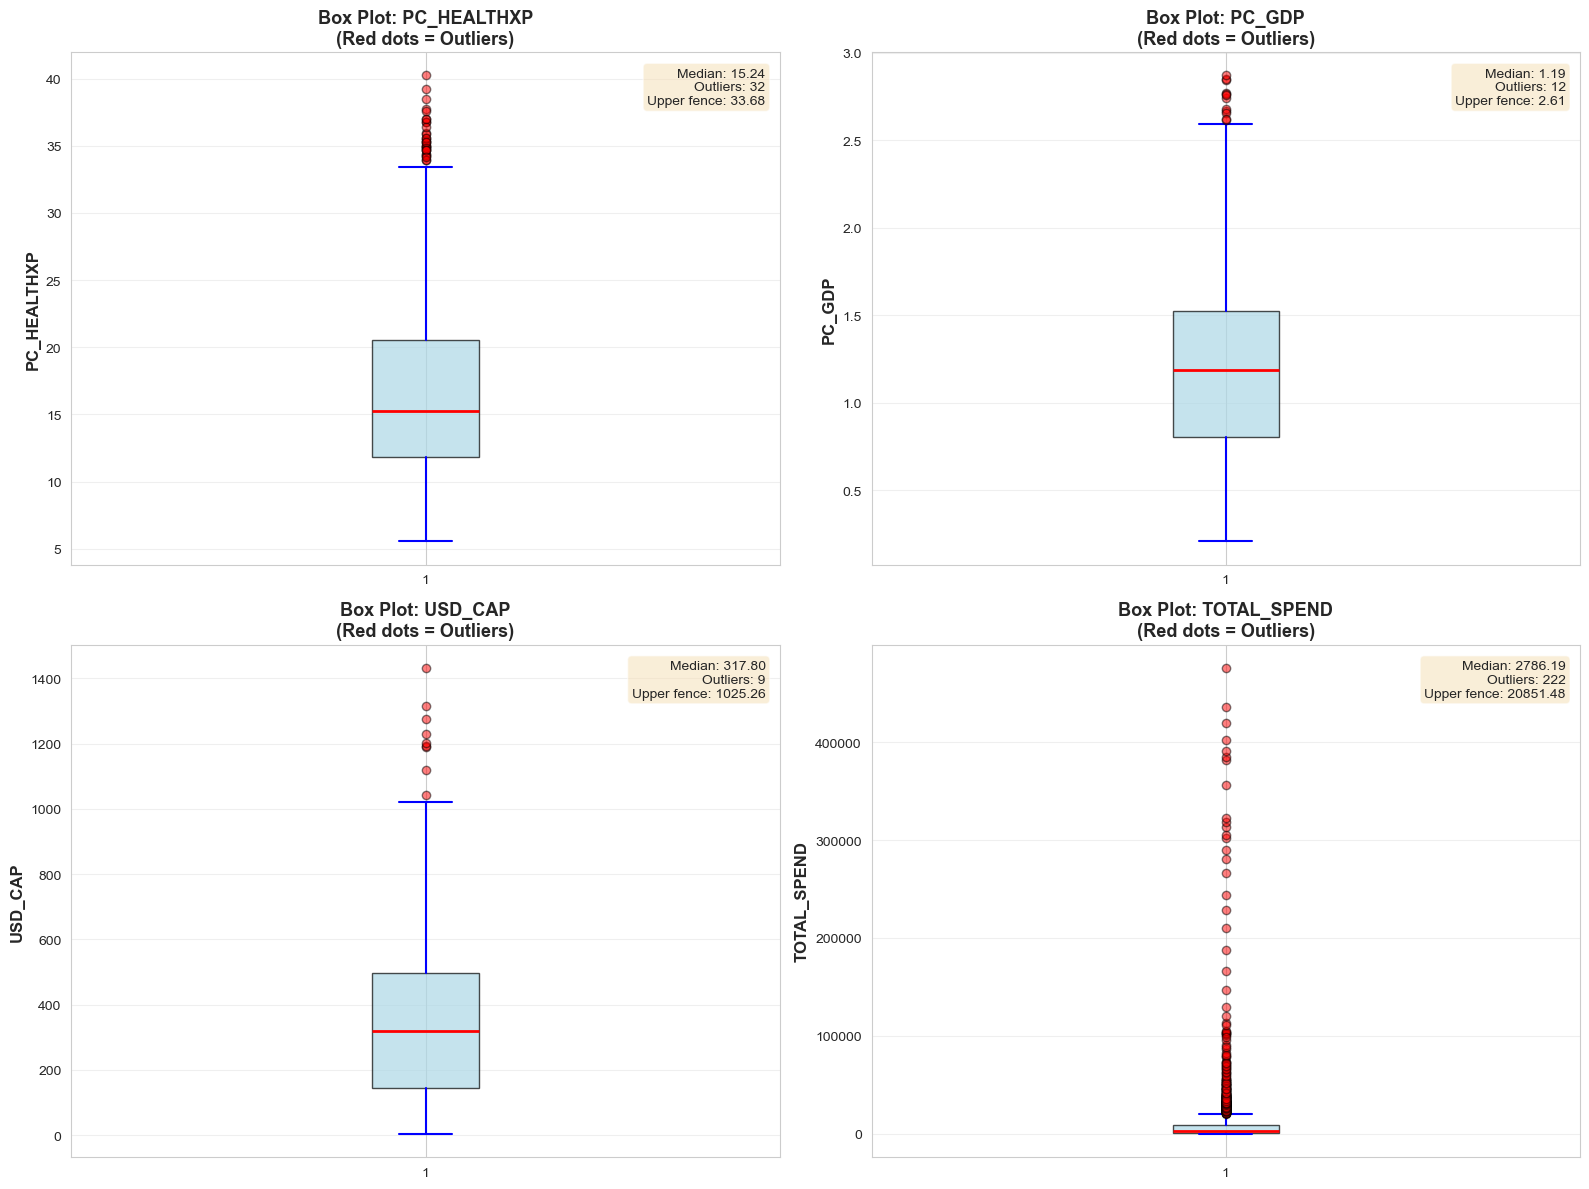

In [35]:
# Step 4 (Extended): Outlier Visualization
# =========================================

print("\n" + "="*70)
print("STEP 4 EXTENDED: OUTLIER VISUALIZATION")
print("="*70)

# 4.V1 Box Plots for All Numeric Variables
print("\n4.V1 Creating Box Plots for Outlier Detection...")

numeric_cols = ['PC_HEALTHXP', 'PC_GDP', 'USD_CAP', 'TOTAL_SPEND']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    # Box plot
    bp = axes[idx].boxplot(df[col], vert=True, patch_artist=True, 
                           boxprops=dict(facecolor='lightblue', alpha=0.7),
                           medianprops=dict(color='red', linewidth=2),
                           whiskerprops=dict(color='blue', linewidth=1.5),
                           capprops=dict(color='blue', linewidth=1.5),
                           flierprops=dict(marker='o', markerfacecolor='red', 
                                          markersize=6, alpha=0.5))
    
    axes[idx].set_ylabel(col, fontsize=12, fontweight='bold')
    axes[idx].set_title(f'Box Plot: {col}\n(Red dots = Outliers)', 
                       fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add statistics text
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    outliers_count = ((df[col] < lower_fence) | (df[col] > upper_fence)).sum()
    
    stats_text = f'Median: {df[col].median():.2f}\n'
    stats_text += f'Outliers: {outliers_count}\n'
    stats_text += f'Upper fence: {upper_fence:.2f}'
    
    axes[idx].text(0.98, 0.97, stats_text, transform=axes[idx].transAxes,
                  fontsize=10, verticalalignment='top', horizontalalignment='right',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


--------

### Step 5 | Final Dataset Creation
**Description:**

Create the final cleaned dataset by filtering to the selected time window (2011-2020) and countries with complete data. This will be your analysis-ready dataset for clustering.


In [38]:
# Step 5: Final Dataset Creation
# ===============================

print("\n" + "="*70)
print("STEP 5: FINAL DATASET CREATION")
print("="*70)

# 5.1 Define the selected time window and filter
print("\n5.1 Filtering Data to Selected Time Window...")

WINDOW_START = 2011
WINDOW_END = 2020

print(f"Selected time window: {WINDOW_START}-{WINDOW_END} ({WINDOW_END - WINDOW_START + 1} years)")

# Filter by time window
df_filtered = df[(df['YEAR'] >= WINDOW_START) & (df['YEAR'] <= WINDOW_END)].copy()

print(f"Records after time filter: {len(df_filtered)}")
print(f"Countries in filtered data: {df_filtered['COUNTRY'].nunique()}")


STEP 5: FINAL DATASET CREATION

5.1 Filtering Data to Selected Time Window...
Selected time window: 2011-2020 (10 years)
Records after time filter: 396
Countries in filtered data: 42


In [39]:
# 5.2 Identify countries with complete data in the window
print("\n5.2 Identifying Countries with Complete Data...")

years_in_window = WINDOW_END - WINDOW_START + 1
complete_countries = []
incomplete_countries = []

for country in df_filtered['COUNTRY'].unique():
    country_data = df_filtered[df_filtered['COUNTRY'] == country]
    if len(country_data) == years_in_window:
        complete_countries.append(country)
    else:
        incomplete_countries.append({
            'Country': country,
            'Available': len(country_data),
            'Missing': years_in_window - len(country_data)
        })

print(f"\n✓ Countries with COMPLETE data ({years_in_window} years): {len(complete_countries)}")
print(f"✗ Countries with INCOMPLETE data: {len(incomplete_countries)}")

if incomplete_countries:
    print("\nIncomplete countries to be excluded:")
    incomplete_df = pd.DataFrame(incomplete_countries).sort_values('Missing')
    print(incomplete_df.to_string(index=False))


5.2 Identifying Countries with Complete Data...

✓ Countries with COMPLETE data (10 years): 36
✗ Countries with INCOMPLETE data: 6

Incomplete countries to be excluded:
Country  Available  Missing
    BGR          9        1
    GBR          8        2
    MLT          7        3
    BRA          5        5
    COL          5        5
    CHL          2        8


In [40]:
# 5.3 Create final dataset with only complete countries
print("\n5.3 Creating Final Clean Dataset...")

df_final = df_filtered[df_filtered['COUNTRY'].isin(complete_countries)].copy()

# Sort by country and year for better organization
df_final = df_final.sort_values(['COUNTRY', 'YEAR']).reset_index(drop=True)

print(f"\nFinal dataset created!")
print(f"  Countries: {len(complete_countries)}")
print(f"  Years: {years_in_window}")
print(f"  Total records: {len(df_final)}")
print(f"  Columns: {list(df_final.columns)}")


5.3 Creating Final Clean Dataset...

Final dataset created!
  Countries: 36
  Years: 10
  Total records: 360
  Columns: ['COUNTRY', 'YEAR', 'PC_HEALTHXP', 'PC_GDP', 'USD_CAP', 'TOTAL_SPEND']


In [41]:
# 5.4 Final dataset summary
print("\n5.4 Final Dataset Summary:")
print(f"\n{'='*70}")
print(df_final.describe())


5.4 Final Dataset Summary:

              YEAR  PC_HEALTHXP      PC_GDP      USD_CAP    TOTAL_SPEND
count   360.000000   360.000000  360.000000   360.000000     360.000000
mean   2015.500000    16.828475    1.382739   525.024358   23389.973111
std       2.876279     6.595045    0.427667   185.848615   63114.891505
min    2011.000000     6.436000    0.528000   110.724000     152.850000
25%    2013.000000    12.119500    1.127750   411.722500    1783.132500
50%    2015.500000    15.439000    1.365500   512.680500    5250.845000
75%    2018.000000    20.812000    1.636000   602.692750   18140.580000
max    2020.000000    39.231000    2.870000  1315.218000  436030.190000


In [42]:
# 5.5 Verify data completeness
print("\n5.5 Final Data Quality Check:")
print(f"  Missing values: {df_final.isnull().sum().sum()}")
print(f"  Duplicate rows: {df_final.duplicated().sum()}")
print(f"  Expected records: {len(complete_countries)} × {years_in_window} = {len(complete_countries) * years_in_window}")
print(f"  Actual records: {len(df_final)}")
print(f"  ✓ Match: {len(df_final) == len(complete_countries) * years_in_window}")


5.5 Final Data Quality Check:
  Missing values: 0
  Duplicate rows: 0
  Expected records: 36 × 10 = 360
  Actual records: 360
  ✓ Match: True


In [44]:
# 5.6 Show countries included
print("\n5.6 Countries Included in Final Dataset:")
print(f"\n{len(complete_countries)} countries:")

# Print in rows of 10 for readability
countries_sorted = sorted(complete_countries)
for i in range(0, len(countries_sorted), 10):
    print("  " + ", ".join(countries_sorted[i:i+10]))


5.6 Countries Included in Final Dataset:

36 countries:
  AUS, AUT, BEL, CAN, CHE, CRI, CYP, CZE, DEU, DNK
  ESP, EST, FIN, FRA, GRC, HRV, HUN, IRL, ISL, ISR
  ITA, JPN, KOR, LTU, LUX, LVA, MEX, NLD, NOR, POL
  PRT, ROU, SVK, SVN, SWE, USA


In [48]:
# 5.7 Display sample of final dataset
print("\n5.7 Sample of Final Dataset:")
print("\nFirst 5 rows:")
print(df_final.head())

print("\nLast 5 rows:")
print(df_final.tail())

print("\nRandom sample (6 rows):")
print(df_final.sample(6, random_state=42))


5.7 Sample of Final Dataset:

First 5 rows:
  COUNTRY  YEAR  PC_HEALTHXP  PC_GDP  USD_CAP  TOTAL_SPEND
0     AUS  2011       15.311   1.307  583.222     13029.19
1     AUS  2012       15.308   1.328  589.993     13412.59
2     AUS  2013       14.345   1.255  586.402     13562.38
3     AUS  2014       12.498   1.229  569.455     13368.35
4     AUS  2015       12.442   1.267  594.233     14152.25

Last 5 rows:
    COUNTRY  YEAR  PC_HEALTHXP  PC_GDP   USD_CAP  TOTAL_SPEND
355     USA  2016       12.263   2.060  1192.301    385198.78
356     USA  2017       11.954   2.004  1200.769    390396.57
357     USA  2018       11.766   1.957  1229.266    401771.09
358     USA  2019       11.767   1.961  1277.032    419287.86
359     USA  2020       11.037   2.070  1315.218    436030.19

Random sample (6 rows):
    COUNTRY  YEAR  PC_HEALTHXP  PC_GDP  USD_CAP  TOTAL_SPEND
224     KOR  2015       21.061   1.388  519.359     26495.07
42      CHE  2013       10.228   1.062  595.626      4818.22
285    

In [49]:
# 5.8 Export options (optional - uncomment to save)
print("\n5.8 Export Final Dataset:")

df_final.to_csv('../Data/processing/cleaned_data_2011_2020.csv', index=False)
print("✓ File saved: ../Data/processing/cleaned_data_2011_2020.csv")



5.8 Export Final Dataset:
✓ File saved: ../Data/processing/cleaned_data_2011_2020.csv


In [50]:
# 5.9 Create a summary report
print("\n" + "="*70)
print("DATA CLEANING & PREPROCESSING SUMMARY REPORT")
print("="*70)

print(f"""
ORIGINAL DATASET:
  - Records: {len(df)}
  - Countries: {df['COUNTRY'].nunique()}
  - Years: {df['YEAR'].min()}-{df['YEAR'].max()} ({df['YEAR'].max() - df['YEAR'].min() + 1} years)
  - Missing values: 0
  - Duplicates: 0

FINAL DATASET:
  - Records: {len(df_final)}
  - Countries: {len(complete_countries)}
  - Years: {WINDOW_START}-{WINDOW_END} ({years_in_window} years)
  - Missing values: 0
  - Duplicates: 0
  - Completeness: 100%

EXCLUDED:
  - Countries dropped: {len(incomplete_countries)}
  - Years outside window: {len(df) - len(df_filtered)}
  - Records excluded: {len(df) - len(df_final)} ({(len(df) - len(df_final))/len(df)*100:.1f}%)

DATA QUALITY:
  ✓ No missing values
  ✓ No duplicates
  ✓ No negative values
  ✓ All data types correct
  ✓ All values within valid ranges
  ✓ Complete time series for all countries

READY FOR:
  ✓ Clustering analysis
  ✓ Feature engineering
  ✓ Market segmentation
  ✓ Statistical modeling
""")

print("="*70)


DATA CLEANING & PREPROCESSING SUMMARY REPORT

ORIGINAL DATASET:
  - Records: 1341
  - Countries: 44
  - Years: 1970-2022 (53 years)
  - Missing values: 0
  - Duplicates: 0

FINAL DATASET:
  - Records: 360
  - Countries: 36
  - Years: 2011-2020 (10 years)
  - Missing values: 0
  - Duplicates: 0
  - Completeness: 100%

EXCLUDED:
  - Countries dropped: 6
  - Years outside window: 945
  - Records excluded: 981 (73.2%)

DATA QUALITY:
  ✓ No missing values
  ✓ No duplicates
  ✓ No negative values
  ✓ All data types correct
  ✓ All values within valid ranges
  ✓ Complete time series for all countries

READY FOR:
  ✓ Clustering analysis
  ✓ Feature engineering
  ✓ Market segmentation
  ✓ Statistical modeling

